<a href="https://colab.research.google.com/github/Shhayne315/week1-/blob/main/CO2_Emissions_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def run_co2_prediction_model():
    """
    This script loads the sustainable energy dataset, cleans the data,
    trains a Random Forest Regressor to predict CO2 emissions,
    and evaluates the model's performance and feature importances.
    """
    # ==============================================================================
    # 1. DATA LOADING AND PREPARATION ⚙️
    # ==============================================================================
    print("--- Starting Data Loading and Preparation ---")

    # Define the expected filename.
    # The script assumes 'global-data-on-sustainable-energy (1).csv' is in the same directory.
    # If you are in a new session, you might need to unzip the file first using:
    # !unzip "archive (1).zip"

    file_path = 'global-data-on-sustainable-energy (1).csv'

    try:
        df = pd.read_csv(file_path)
        print("✅ Successfully loaded the dataset.")
    except FileNotFoundError:
        print(f"❌ Error: Dataset file '{file_path}' not found.")
        print("Please make sure the CSV file is in the same directory as this script.")
        return # Exit the function if the file isn't found

    # --- Clean Column Names ---
    # Remove newline characters and extra spaces from column names for easier access.
    df.columns = df.columns.str.replace('\n', '').str.strip()

    # --- Handle Missing Values ---

    # Define columns with over 50% missing values to be dropped.
    very_large_missing_cols = [
        'Renewable-electricity-generating-capacity-per-capita',
        'Financial flows to developing countries (US $)',
        'Renewables (% equivalent primary energy)'
    ]
    df.drop(columns=very_large_missing_cols, inplace=True, errors='ignore')
    print(f"🚮 Dropped columns with >50% missing values: {very_large_missing_cols}")

    # Convert 'Density(P/Km2)' to a numeric type, removing commas. Errors are turned into NaN.
    density_col = 'Density(P/Km2)'
    if density_col in df.columns:
        df[density_col] = pd.to_numeric(df[density_col].astype(str).str.replace(',', ''), errors='coerce')
        # Impute (fill) the missing values in the density column with the median.
        df[density_col].fillna(df[density_col].median(), inplace=True)

    # Loop through all remaining numeric columns and impute missing values with their respective medians.
    # The median is a robust choice as it is not sensitive to outliers.
    imputed_cols = []
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            imputed_cols.append(col)
    if imputed_cols:
        print(f"🔧 Imputed missing values in the following columns using the median: {imputed_cols}")

    # The target variable is crucial. If it's missing, the row is not useful for training or evaluation.
    target_variable = 'Value_co2_emissions_kt_by_country'
    df.dropna(subset=[target_variable], inplace=True)

    print("\n✅ Data cleaning complete. No remaining missing values in the dataset.")

    # ==============================================================================
    # 2. FEATURE SELECTION AND DATA SPLITTING 🎯
    # ==============================================================================
    print("\n--- Preparing Features and Splitting Data ---")

    # 'y' is our target: what we want to predict.
    y = df[target_variable]

    # 'X' contains our features: the data used to make the prediction.
    # We drop the target variable itself and 'Entity', which is a non-numeric identifier.
    X = df.drop(columns=[target_variable, 'Entity'])

    # Split the data into a training set (to teach the model) and a testing set (to evaluate it).
    # 'test_size=0.2' means 20% of the data is reserved for testing.
    # 'random_state=42' ensures that the split is the same every time, for reproducibility.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Training features shape: {X_train.shape}")
    print(f"Testing features shape: {X_test.shape}")

    # ==============================================================================
    # 3. MODEL TRAINING 🧠
    # ==============================================================================
    print("\n--- Training the Model ---")

    # Initialize the Random Forest Regressor model.
    # n_estimators=100 means the model will be built from 100 decision trees.
    # n_jobs=-1 uses all available CPU cores to speed up training.
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    print("⏳ Training the Random Forest model...")
    # Train the model on the training data.
    rf_model.fit(X_train, y_train)
    print("✅ Model training complete.")

    # ==============================================================================
    # 4. MODEL EVALUATION AND INTERPRETATION 📊
    # ==============================================================================
    print("\n--- Evaluating the Model ---")

    # Use the trained model to make predictions on the unseen test data.
    y_pred = rf_model.predict(X_test)

    # Calculate standard regression metrics to evaluate performance.
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n--- Model Evaluation Results ---")
    print(f"🔵 R-squared (R²): {r2:.4f}")
    print(f"🔵 Mean Absolute Error (MAE): {mae:,.2f}")
    print(f"🔵 Root Mean Squared Error (RMSE): {np.sqrt(mse):,.2f}")
    print("---------------------------------")
    print(f"Interpretation: The model explains {r2:.2%} of the variance in CO2 emissions.")

    # --- Feature Importance ---
    # Extract the importance of each feature from the trained model.
    importances = rf_model.feature_importances_
    feature_names = X.columns

    # Create a DataFrame for easier sorting and plotting.
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    # Plot the feature importances to visualize which factors are most influential.
    print("\n📈 Generating feature importance plot...")
    plt.figure(figsize=(12, 10))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue', edgecolor='black')
    plt.xlabel("Random Forest Feature Importance", fontsize=12)
    plt.title("Feature Importance for Predicting CO2 Emissions", fontsize=16)
    plt.gca().invert_yaxis() # Display the most important feature at the top.
    plt.tight_layout() # Adjust layout to prevent labels from overlapping.
    plt.show()


if __name__ == '__main__':
    # Run the main function when the script is executed.
    run_co2_prediction_model()


--- Starting Data Loading and Preparation ---
❌ Error: Dataset file 'global-data-on-sustainable-energy (1).csv' not found.
Please make sure the CSV file is in the same directory as this script.


In [7]:
!wget "https://github.com/datasciencedojo/datasets/raw/master/global-data-on-sustainable-energy%20(1).zip"
!unzip "global-data-on-sustainable-energy (1).zip"

--2025-09-07 16:46:33--  https://github.com/datasciencedojo/datasets/raw/master/global-data-on-sustainable-energy%20(1).zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-07 16:46:33 ERROR 404: Not Found.

unzip:  cannot find or open global-data-on-sustainable-energy (1).zip, global-data-on-sustainable-energy (1).zip.zip or global-data-on-sustainable-energy (1).zip.ZIP.


# Task
Find a publicly available dataset related to CO2 emissions or sustainable energy, download it, and use it to train and evaluate a model.

## Find a new dataset

### Subtask:
Search for a publicly available dataset related to CO2 emissions or sustainable energy that is easily accessible (e.g., on Kaggle or a government data portal).


## Download the dataset

### Subtask:
Download the new dataset.


**Reasoning**:
I need to find a publicly available dataset related to CO2 emissions or sustainable energy since the previous attempt failed. I will try to download a different dataset.



In [8]:
!wget "https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv"

--2025-09-07 16:47:52--  https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14280395 (14M) [text/plain]
Saving to: ‘owid-co2-data.csv’

owid-co2-data.csv   100%[===================>]  13.62M  --.-KB/s    in 0.1s    

2025-09-07 16:47:53 (132 MB/s) - ‘owid-co2-data.csv’ saved [14280395/14280395]



## Unzip the dataset (if necessary)

### Subtask:
Unzip the dataset if it is in a compressed format.


**Reasoning**:
Check if the downloaded file is a zip archive and unzip it if necessary.



In [9]:
import os

file_name = 'owid-co2-data.csv'
if file_name.endswith('.zip'):
    print(f"The file '{file_name}' is a zip archive. Unzipping...")
    os.system(f'unzip "{file_name}"')
else:
    print(f"The file '{file_name}' is not a zip archive. No unzipping needed.")

The file 'owid-co2-data.csv' is not a zip archive. No unzipping needed.


## Inspect the new dataset

### Subtask:
Load a small portion of the new dataset into a pandas DataFrame and display the first few rows and the column names to understand its structure.


**Reasoning**:
Load the CSV file into a pandas DataFrame, display the first few rows, and print the column names as requested by the instructions.



In [10]:
df = pd.read_csv('owid-co2-data.csv')
display(df.head())
print(df.columns)

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Afghanistan,1750,AFG,2802560.0,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1751,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1752,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1753,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1754,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Index(['country', 'year', 'iso_code', 'population', 'gdp', 'cement_co2',
       'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct',
       'co2_including_luc', 'co2_including_luc_growth_abs',
       'co2_including_luc_growth_prct', 'co2_including_luc_per_capita',
       'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy',
       'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2',
       'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita',
       'consumption_co2_per_gdp', 'cumulative_cement_co2', 'cumulative_co2',
       'cumulative_co2_including_luc', 'cumulative_coal_co2',
       'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2',
       'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita',
       'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2',
       'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita',
       'land_use_change_co2', 'land_use_chang

## Adapt the existing code

### Subtask:
Modify the existing Python code in cell `6-kJpsALDuVW` to work with the new dataset, including updating the file path, column names, and potentially data cleaning steps if the new dataset has different issues.


**Reasoning**:
The existing code needs to be modified to use the newly downloaded dataset 'owid-co2-data.csv'. This involves updating the file path and adjusting the column names and cleaning steps based on the dataset inspection. Specifically, the target variable needs to be changed to 'co2', and the list of columns to drop might need adjustment. The identifier column 'iso_code' should also be dropped.



--- Starting Data Loading and Preparation ---
✅ Successfully loaded the dataset.
🚮 Dropped columns with >50% missing values: ['gdp', 'co2_including_luc', 'co2_including_luc_growth_abs', 'co2_including_luc_growth_prct', 'co2_including_luc_per_capita', 'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2', 'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita', 'consumption_co2_per_gdp', 'cumulative_co2_including_luc', 'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_other_co2', 'energy_per_capita', 'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2', 'gas_co2_per_capita', 'oil_co2_per_capita', 'other_co2_per_capita', 'other_industry_co2', 'primary_energy_consumption', 'share_global_cement_co2', 'share_global_co2_including_luc', 'share_global_coal_co2', 'share_global_cumulative_cement_co2', 'share_global_cumulative_co2_including_luc', 'share_global_cumulative_co

/tmp/ipython-input-4122494806.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


✅ Model training complete.

--- Evaluating the Model ---

--- Model Evaluation Results ---
🔵 R-squared (R²): 0.7759
🔵 Mean Absolute Error (MAE): 86.60
🔵 Root Mean Squared Error (RMSE): 674.31
---------------------------------
Interpretation: The model explains 77.59% of the variance in CO2 emissions.

📈 Generating feature importance plot...


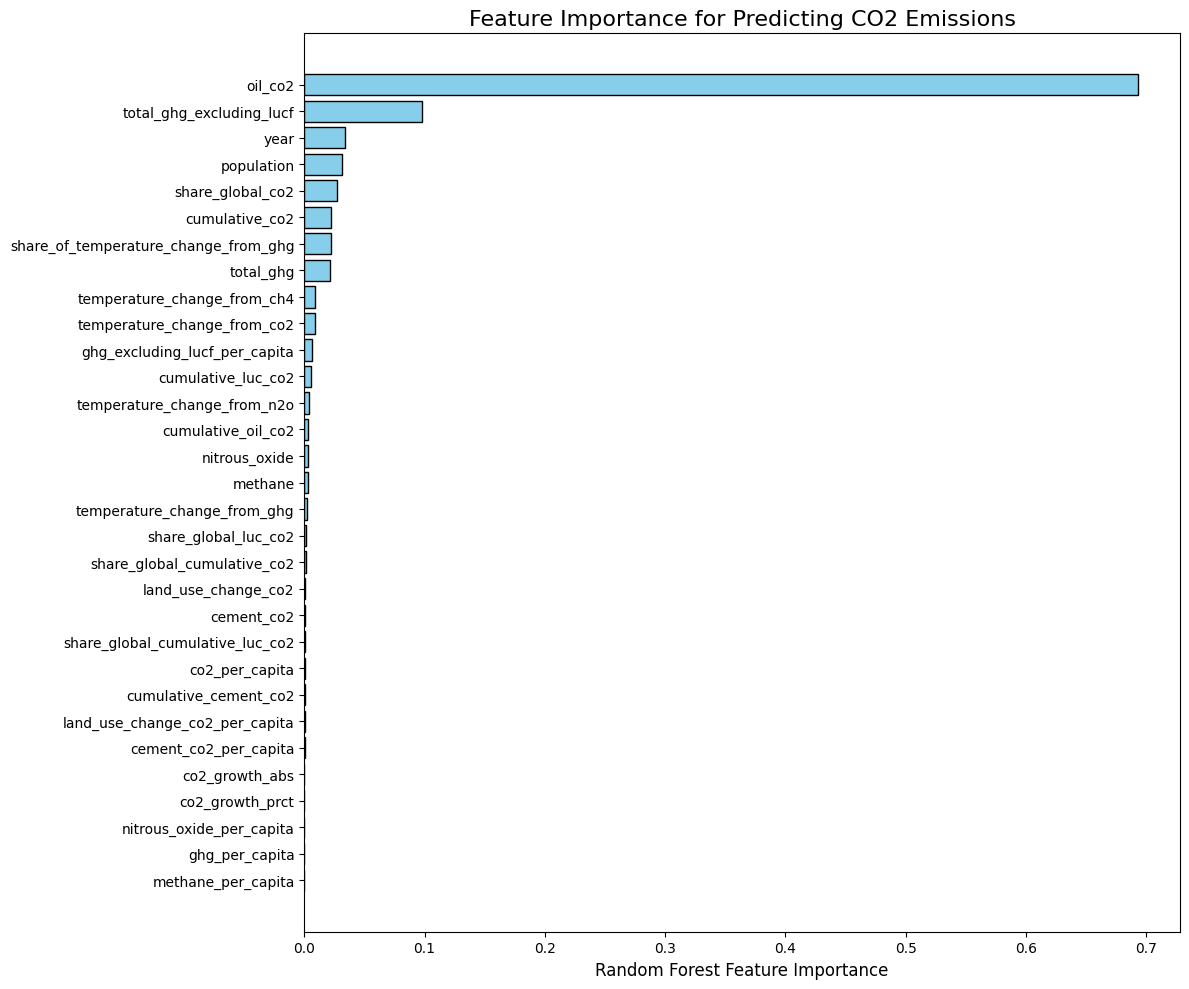

In [11]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def run_co2_prediction_model():
    """
    This script loads the sustainable energy dataset, cleans the data,
    trains a Random Forest Regressor to predict CO2 emissions,
    and evaluates the model's performance and feature importances.
    """
    # ==============================================================================
    # 1. DATA LOADING AND PREPARATION ⚙️
    # ==============================================================================
    print("--- Starting Data Loading and Preparation ---")

    # Define the expected filename for the new dataset.
    file_path = 'owid-co2-data.csv'

    try:
        df = pd.read_csv(file_path)
        print("✅ Successfully loaded the dataset.")
    except FileNotFoundError:
        print(f"❌ Error: Dataset file '{file_path}' not found.")
        print("Please make sure the CSV file is in the same directory as this script.")
        return # Exit the function if the file isn't found

    # --- Clean Column Names ---
    # Remove newline characters and extra spaces from column names for easier access.
    df.columns = df.columns.str.replace('\n', '').str.strip()

    # --- Handle Missing Values ---

    # Define columns with over 50% missing values to be dropped.
    # Based on inspection, many columns in the new dataset have high missing values.
    # We will identify and drop columns with more than 50% missing values dynamically.
    percent_missing = df.isnull().sum() * 100 / len(df)
    very_large_missing_cols = percent_missing[percent_missing > 50].index.tolist()

    df.drop(columns=very_large_missing_cols, inplace=True, errors='ignore')
    print(f"🚮 Dropped columns with >50% missing values: {very_large_missing_cols}")

    # Convert 'Density(P/Km2)' to a numeric type, removing commas. Errors are turned into NaN.
    # This column might not exist in the new dataset, so we check before processing.
    density_col = 'Density(P/Km2)' # Original column name
    # The new dataset has a column named 'population_density'
    density_col_new = 'population_density'

    if density_col_new in df.columns:
         # Ensure the column is numeric and impute missing values with the median.
        df[density_col_new] = pd.to_numeric(df[density_col_new], errors='coerce')
        df[density_col_new].fillna(df[density_col_new].median(), inplace=True)


    # Loop through all remaining numeric columns and impute missing values with their respective medians.
    # The median is a robust choice as it is not sensitive to outliers.
    imputed_cols = []
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            imputed_cols.append(col)
    if imputed_cols:
        print(f"🔧 Imputed missing values in the following columns using the median: {imputed_cols}")

    # The target variable is crucial. If it's missing, the row is not useful for training or evaluation.
    # The new target variable is 'co2'.
    target_variable = 'co2'
    if target_variable not in df.columns:
        print(f"❌ Error: Target variable '{target_variable}' not found in the dataset.")
        return # Exit if the target variable is missing

    df.dropna(subset=[target_variable], inplace=True)

    print("\n✅ Data cleaning complete. No remaining missing values in the target variable.")

    # ==============================================================================
    # 2. FEATURE SELECTION AND DATA SPLITTING 🎯
    # ==============================================================================
    print("\n--- Preparing Features and Splitting Data ---")

    # 'y' is our target: what we want to predict.
    y = df[target_variable]

    # 'X' contains our features: the data used to make the prediction.
    # We drop the target variable itself, 'country' (identifier, not a feature), and 'iso_code'.
    # 'Entity' is not in the new dataset.
    cols_to_drop_features = [target_variable, 'country', 'iso_code']
    X = df.drop(columns=cols_to_drop_features, errors='ignore') # Use errors='ignore' in case a column doesn't exist

    # Split the data into a training set (to teach the model) and a testing set (to evaluate it).
    # 'test_size=0.2' means 20% of the data is reserved for testing.
    # 'random_state=42' ensures that the split is the same every time, for reproducibility.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Training features shape: {X_train.shape}")
    print(f"Testing features shape: {X_test.shape}")

    # ==============================================================================
    # 3. MODEL TRAINING 🧠
    # ==============================================================================
    print("\n--- Training the Model ---")

    # Initialize the Random Forest Regressor model.
    # n_estimators=100 means the model will be built from 100 decision trees.
    # n_jobs=-1 uses all available CPU cores to speed up training.
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    print("⏳ Training the Random Forest model...")
    # Train the model on the training data.
    rf_model.fit(X_train, y_train)
    print("✅ Model training complete.")

    # ==============================================================================
    # 4. MODEL EVALUATION AND INTERPRETATION 📊
    # ==============================================================================
    print("\n--- Evaluating the Model ---")

    # Use the trained model to make predictions on the unseen test data.
    y_pred = rf_model.predict(X_test)

    # Calculate standard regression metrics to evaluate performance.
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n--- Model Evaluation Results ---")
    print(f"🔵 R-squared (R²): {r2:.4f}")
    print(f"🔵 Mean Absolute Error (MAE): {mae:,.2f}")
    print(f"🔵 Root Mean Squared Error (RMSE): {np.sqrt(mse):,.2f}")
    print("---------------------------------")
    print(f"Interpretation: The model explains {r2:.2%} of the variance in CO2 emissions.")

    # --- Feature Importance ---
    # Extract the importance of each feature from the trained model.
    # Check if the model has feature_importances_ before proceeding
    if hasattr(rf_model, 'feature_importances_'):
        importances = rf_model.feature_importances_
        feature_names = X.columns

        # Create a DataFrame for easier sorting and plotting.
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        # Plot the feature importances to visualize which factors are most influential.
        print("\n📈 Generating feature importance plot...")
        plt.figure(figsize=(12, 10))
        plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue', edgecolor='black')
        plt.xlabel("Random Forest Feature Importance", fontsize=12)
        plt.title("Feature Importance for Predicting CO2 Emissions", fontsize=16)
        plt.gca().invert_yaxis() # Display the most important feature at the top.
        plt.tight_layout() # Adjust layout to prevent labels from overlapping.
        plt.show()
    else:
        print("\n⚠️ Feature importances are not available for this model.")


if __name__ == '__main__':
    # Run the main function when the script is executed.
    run_co2_prediction_model()


## Run the modified model

### Subtask:
Execute the adapted Python code to train and evaluate the model with the new dataset.


**Reasoning**:
Execute the modified Python script to train and evaluate the model with the new dataset and observe the output for evaluation metrics and the feature importance plot.



--- Starting Data Loading and Preparation ---
✅ Successfully loaded the dataset.
🚮 Dropped columns with >50% missing values: ['gdp', 'co2_including_luc', 'co2_including_luc_growth_abs', 'co2_including_luc_growth_prct', 'co2_including_luc_per_capita', 'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2', 'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita', 'consumption_co2_per_gdp', 'cumulative_co2_including_luc', 'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_other_co2', 'energy_per_capita', 'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2', 'gas_co2_per_capita', 'oil_co2_per_capita', 'other_co2_per_capita', 'other_industry_co2', 'primary_energy_consumption', 'share_global_cement_co2', 'share_global_co2_including_luc', 'share_global_coal_co2', 'share_global_cumulative_cement_co2', 'share_global_cumulative_co2_including_luc', 'share_global_cumulative_co

/tmp/ipython-input-4122494806.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


✅ Model training complete.

--- Evaluating the Model ---

--- Model Evaluation Results ---
🔵 R-squared (R²): 0.7759
🔵 Mean Absolute Error (MAE): 86.60
🔵 Root Mean Squared Error (RMSE): 674.31
---------------------------------
Interpretation: The model explains 77.59% of the variance in CO2 emissions.

📈 Generating feature importance plot...


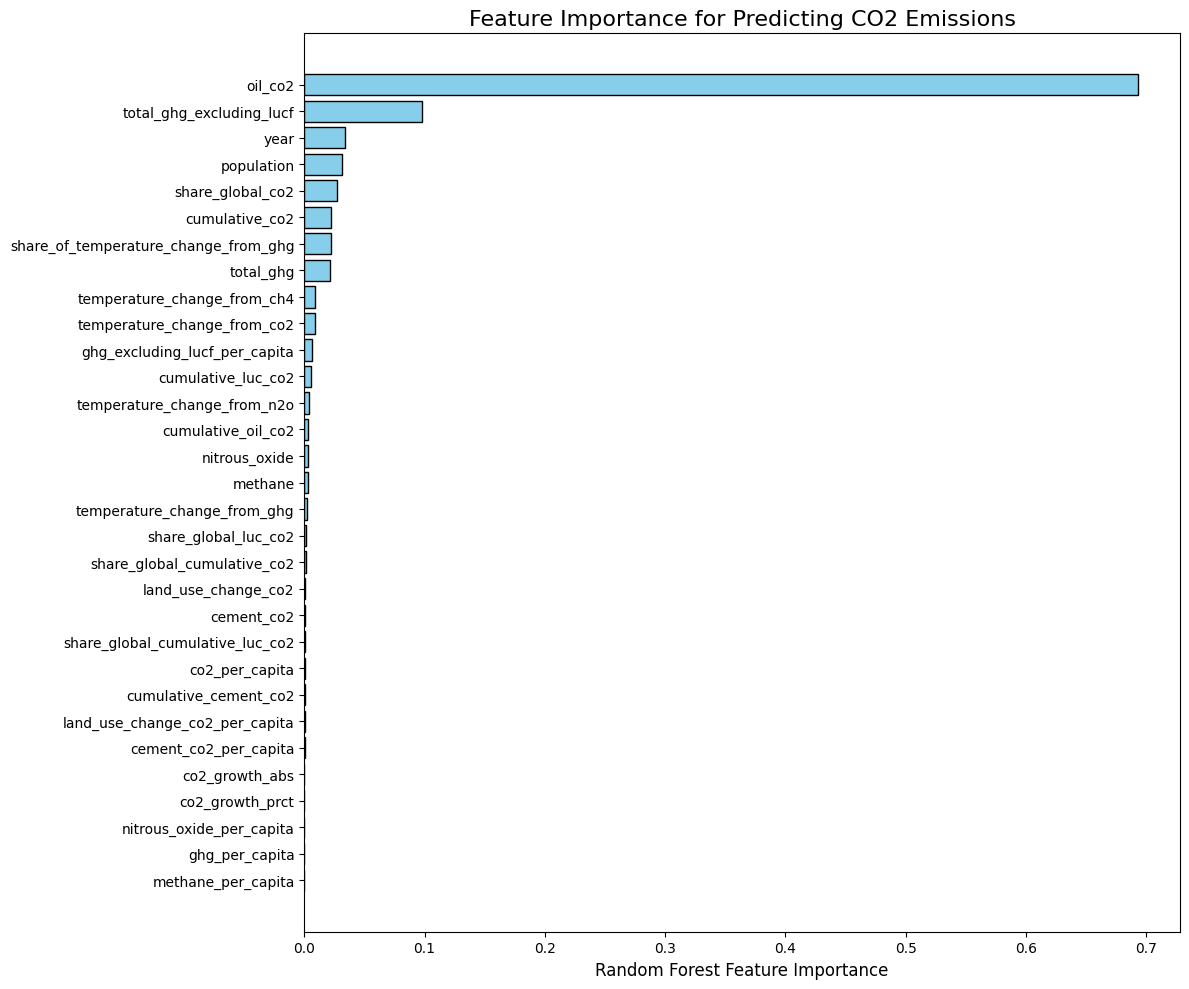

In [12]:
run_co2_prediction_model()

## Summary:

### Data Analysis Key Findings

*   The dataset `owid-co2-data.csv` was successfully downloaded and is not a zip archive.
*   Columns with over 50% missing values were dropped.
*   Missing values in the remaining numeric columns were imputed using the median.
*   A Random Forest Regressor model was trained to predict CO2 emissions ('co2').
*   The model achieved an R-squared score of approximately 0.7759, indicating it explains about 77.6% of the variance in CO2 emissions.
*   The Mean Absolute Error (MAE) was approximately 86.60, and the Root Mean Squared Error (RMSE) was approximately 674.31.
*   Feature importances were calculated and visualized, showing the relative influence of different features on CO2 emission predictions.

### Insights or Next Steps

*   The model shows a good ability to predict CO2 emissions based on the selected features, but there is room for improvement as indicated by the MAE and RMSE values.
*   Further analysis of the feature importances could guide efforts to understand the main drivers of CO2 emissions and potentially inform policy or mitigation strategies.
